In [1]:
import sys, os, time
import h5py
import cv2
import numpy as np
# sys.path.append(os.path.join(os.getcwd(),'../'))
sys.path.append(os.path.join(os.getcwd(),'python/'))
sys.path.append(os.path.join(os.getcwd(),'examples/'))
import darknet as dn
from detectorScipyOpencv import array_to_image, detect2
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.lines as mlines
from math import sqrt


def IOU( x1, y1, w1, h1, x2, y2, w2, h2):
    box1 = ( x1-w1/2.0, y1-h1/2.0, x1+w1/2.0, y1+h1/2.0)
    box2 = ( x2-w2/2.0, y2-h2/2.0, x2+w2/2.0, y2+h2/2.0)
    xA = max( box1[0], box2[0] )
    xB = min( box1[2], box2[2] )
    yA = max( box1[1], box2[1] )
    yB = min( box1[3], box2[3] )

    w = (xB-xA)
    h = (yB-yA)
    if w <= 0 or h <= 0: return 0
    interArea = h * w
    #if interArea <= 0: return 0

    areaA = (box1[2]-box1[0]) * (box1[3]-box1[1])
    areaB = (box2[2]-box2[0]) * (box2[3]-box2[1])
    return interArea / (areaA+areaB-interArea)


/home/liponan/.conda/envs/yolo/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

rootPath = '/home/liponan/pkg/darknet/'
imagePath = '/home/liponan/data/cs231n/test/'
outputPath = 'debug/'
boxSize = 11
imgSrc = 0 # 0: PNG; 1: CXI; 2: psana
h = 1480
w = 1552

yoloMatch = False
dropletMatch = True
yoloBox = True
dropletBox = True
showText = False

# yolo setting
dataPath = 'cfg/peaks.data'
# cfgPath = 'cfg/newpeaksv2.cfg'
# cfgPath = 'cfg/newpeaks.cfg'
# cfgPath = 'cfg/tiny-peaks-test.cfg'
#weightPath = 'backup/training20171129/peaks_10000.weights' # 51
#weightPath = 'backup/training20171203/peaks_30000.weights' # 11
#weightPath = 'backup/training20171206/peaks.backup'# 21
#weightPath = 'backup/training20171215/peaks.backup'# 7
#weightPath = 'backup/tiny-peaks.backup'
# weightPath = 'backup/newpeaksv2.backup' # latest weights
# weightPath = 'backup/newpeaksv2_900.weights' # latest weights
# weightPath = 'backup/newpeaks_900.weights'
# weightPath = 'backup/newpeaks.backup'
# weightPath = 'backup/peaks_40000.weights'

# cfgPath = 'cfg/newpeaksv2.1.cfg'
# weightPath = 'backup/newpeaksv2.1_final.weights' # latest weights

# cfgPath = 'cfg/newpeaksv4-test.cfg'
# weightPath = 'backup/newpeaksv4_4400.weights' # latest weights

cfgPath = 'cfg/newpeaksv5-test.cfg'
weightPath = 'backup/newpeaksv5_6240.weights' # latest weights

# cfgPath = 'cfg/yolov3-peaks-test.cfg'
# weightPath = 'backup/yolov3-peaks.backup'

# cfgPath = 'cfg/yolov2-peaks-test.cfg'
# weightPath = 'backup/yolov2-peaks.backup'
# weightPath = 'backup/yolov2-peaks_900.weights'

# cfgPath = 'cfg/yolov2-tiny-peaks-test.cfg'
# weightPath = 'backup/yolov2-tiny-peaks.backup'

netReady = False
currentRun = None
imgFlag = False

thresh = 0.20
r = 1

provide val index: 346 0.1
detection thresh: 0.1
setting up YOLO......
detected in 1.28515315056 secs
>> droplet found 117 peaks!
>> yolo    found 246 peaks!
peak 0: (64, 0.46286903453726036, 0.30544796694631854)
peak 1: (70, 76.96520323951371, 0)
peak 2: (70, 0.574179097226985, 0.31488599038098336)
peak 3: (73, 0.731333962746981, 0.3227494534812236)
peak 4: (36, 0.48452027180726853, 0.2997178424760376)
peak 5: (32, 0.3643484910385261, 0.29957423619191653)
peak 6: (171, 0.639648567993209, 0.28483530586827105)
peak 7: (93, 0.35509459649596264, 0.31907544475156896)
peak 8: (35, 0.817880406682526, 0.3071018609674911)
peak 9: (74, 0.2902828325633386, 0.3338650022096847)
peak 10: (12, 0.8160146448596767, 0.31871481494334314)
peak 11: (134, 0.23229100044793585, 0.2326411991823139)
peak 12: (0, 0.895861765571947, 0.39974135322067134)
peak 13: (103, 0.30956796628682676, 0.2948685848646014)
peak 14: (237, 0.7963787484252766, 0.1293902721932134)
peak 15: (136, 0.725067256240465, 0.30341206082391

provide val index: 346 0.4
detection thresh: 0.4
detected in 1.0835108757 secs
>> droplet found 117 peaks!
>> yolo    found 27 peaks!
peak 0: (12, 295.06517591870244, 0)
peak 1: (17, 265.14957160286235, 0)
peak 2: (12, 279.94014847188004, 0)
peak 3: (12, 226.6506416675319, 0)
peak 4: (12, 215.8918385472498, 0)
peak 5: (17, 73.62132683224876, 0)
peak 6: (7, 88.06571119106336, 0)
peak 7: (7, 76.77982269697422, 0)
peak 8: (12, 26.500486867547014, 0)
peak 9: (7, 72.28777404855141, 0)
peak 10: (12, 0.8160146448596767, 0.31871481494334314)
peak 11: (7, 62.6240719101474, 0)
peak 12: (0, 0.895861765571947, 0.39974135322067134)
peak 13: (7, 33.3030875618498, 0)
peak 14: (7, 36.1668357422558, 0)
peak 15: (12, 24.953673845682907, 0)
peak 16: (7, 0.6300084788990923, 0.31199398988368265)
peak 17: (16, 1.264600705015557, 0.3187192707238699)
peak 18: (9, 0.6282802051387505, 0.3098557884652019)
peak 19: (21, 1.273018058858644, 0.3128571117385757)
peak 20: (21, 141.16266236984006, 0)
peak 21: (24, 588.

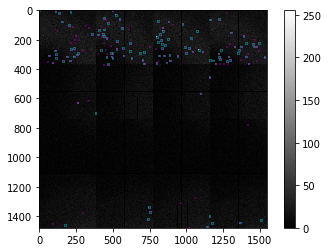

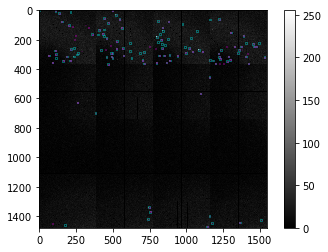

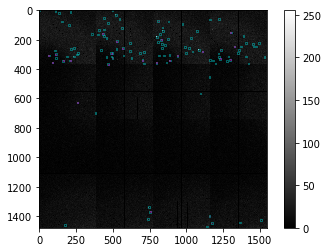

In [3]:
mode = 'test'


while (True):
    userInput = raw_input('provide val index: ')
    if userInput == '': break
    idx = str(userInput).split(' ')
    t = int(idx[0])
    if len(idx) > 1:
        thresh = float(idx[1])
    print('detection thresh: {}'.format(str(thresh)))

    if not netReady:
        print('setting up YOLO......')
        #try:
        dn.set_gpu(0)
        net = dn.load_net( cfgPath, weightPath, 0 )
        meta = dn.load_meta( dataPath )
        netReady = True
#         except:
#             print('try again?')
#         continue

    filename = imagePath + '{}.png'.format(str(t).zfill(6))
    if os.path.isfile( filename ):
        time1 = time.time()
        res = dn.detect(net, meta, filename, thresh)
    else:
        print('{} not found, try again?'.format(filename) )
        continue

    time2 = time.time()
    dt = time2 - time1
    print('detected in {} secs'.format(str(dt)))

    txt = open( filename[:-4] + '.txt' ).read().split('\n')
    
    n = len(res)
    m = len(txt)
    
    posX = np.zeros( (m) )
    posY = np.zeros( (m) )
    for u in range(m-1):
        line = txt[u].split(' ')
#         print(line)
        posX[u] = w * float( line[1] ) 
        posY[u] = h * float( line[2] )
    
    print('>> droplet found {} peaks!'.format(str(m)))
    print('>> yolo    found {} peaks!'.format(str(n)))

    if yoloMatch and n*m > 0:
        yoloDist = 0
        for u in range(n):
            minDist = float('Inf')
            minIdx  = -1
            x = r*res[u][2][0]
            y = r*res[u][2][1]
            for v in range(m):
                dist = sqrt( (x - posX[v])**2 + (y - posY[v])**2 )
                if dist < minDist:
                    minDist = dist
                    minIdx = v
            res[u] = ( res[u][0], res[u][1], res[u][2], (minIdx, minDist) )
            yoloDist += minDist
            print('peak {}: {}'.format(str(u), str(res[u][3])))
        yoloDist /= 1.0*n
        print('avg. distance: {0:.2f}'.format(yoloDist))

    if dropletMatch and n*m > 0:
        nn = []
        dropletDist = 0
        recall = 0
        specif = 0
        dropletIOU = 0
        for v in range(m):
            minDist = float('Inf')
            minIdx = -1
            for u in range(n):
                x = r*res[u][2][0]
                y = r*res[u][2][1]
                dist = sqrt( (x - posX[v])**2 + (y - posY[v])**2 )
                if dist < minDist:
                    minDist = dist
                    minIdx = u
            if minIdx == -1: continue
            iou = IOU( posX[v], posY[v], boxSize, boxSize,
                r*res[minIdx][2][0], r*res[minIdx][2][1], r*res[minIdx][2][2], r*res[minIdx][2][3] )
            if iou > 0.0:
                recall += 1
                dropletDist += minDist
                dropletIOU += iou
            nn.append( (minIdx, minDist, iou) )

            print('peak {}: {}'.format(str(v), str(nn[v])))
        if recall > 0:
            dropletIOU /= float(recall)
            dropletDist /= float(recall)
            specif = float(recall) / n
            recall = float(recall) / m

        print('avg. distance: {0:.2f}'.format(dropletDist))
        print('avg. IOU     : {0:.2f}'.format(dropletIOU))
        print('recall       : {0:.2f}'.format(recall))
        print('precision    : {0:.2f}'.format(specif))


    # plot image
    img = cv2.imread( filename, 0)
    imageShape = img.shape
    h = imageShape[0]
    w = imageShape[1]
    fig, ax = plt.subplots(1)
    cax = ax.imshow(img, vmin=0, vmax=255, cmap="gray")
    cbar = fig.colorbar(cax)

    # plot droplet results
    if dropletBox:
        for i in range(m):
            rect = pat.Rectangle( (posX[i]-(boxSize/2.0), posY[i]-(boxSize/2.0)),
                boxSize, boxSize, color="c", fill=False, linewidth=0.5)
            ax.add_patch(rect)
            if dropletBox and dropletMatch and n*m > 0 and nn[i][2] > 0 and showText:
                ax.text( posX[i], posY[i],
                    str( int(100*nn[i][2]) ), fontsize=4, color='y' )

    # plot yolo results
    if yoloBox:
        for i in range(n):
            if res[i][1] < thresh: continue
            rect = pat.Rectangle( (r*res[i][2][0]-r*res[i][2][2]/2.0, r*res[i][2][1]-r*res[i][2][3]/2.0),
                r*res[i][2][2], r*res[i][2][3], color="m", fill=False, linewidth=0.5,
                alpha=0.2+min(0.8, 0.8/0.40*res[i][1]) )
            ax.add_patch(rect)
            if yoloBox and res[i][1] > 0.01 and showText:
                ax.text( r*res[i][2][0]+r*res[i][2][2]/2.0, r*res[i][2][1]+r*res[i][2][3]/2.0+4,
                    str( int(100*res[i][1]) ), fontsize=4 )

    # plot YOLO vs nearest neighbor
    if yoloMatch and n*m >0:
        for i in range(n):
            if res[i][3][1] > 0.5 * boxSize: continue
            j = res[i][3][0]
            l = mlines.Line2D( [r*res[i][2][0], posX[j]], [r*res[i][2][1], posY[j]],
                color='y', linewidth=0.5 )
            ax.add_line(l)

    # plot DROPLET vs nearest neighbor
    if dropletMatch and n*m > 0:
        for i in range(m):
            if nn[i][1] > 0.5 * boxSize: continue
            j = nn[i][0]
            l = mlines.Line2D( [r*res[j][2][0], posX[i]], [r*res[j][2][1], posY[i]],
                color='y', linewidth=0.5, alpha = 0.5 )
            ax.add_line(l)


    plt.xlim([1, w])
    plt.ylim([h, 1])
        #plt.show()
        #plt.close()
        #plt.savefig(runPath + outputPath +
        #    '_{}.png'.format(str(t).zfill(4)), bbox_inches='tight', dpi=150)
        #plt.clf()
        #plt.cla()
    plt.savefig( rootPath + outputPath + mode + '_{}.png'.format(str(t).zfill(6)), bbox_inces='tight', dpi=600)
    #plt.show()
    #plt.clf()
    #plt.cla()
    #plt.close()

    imgFlag = False
